## Import Necessary Packages 

In [27]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import math
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
import time 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import datasets, linear_model
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

## Import Input Files

In [2]:
user_engagement = pd.read_csv("takehome_user_engagement-intern.csv",sep=",",error_bad_lines=False)
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'], format="%Y-%m-%d")
user_engagement['time_stamp'] = user_engagement['time_stamp'].dt.date
users = pd.read_csv("takehome_users-intern.csv",sep=",",encoding="ISO-8859-1")

In [3]:
users.shape

(12000, 11)

## Target Creation

In [4]:
def adopted_user(user_engagement,users):
    u =  users['object_id'].unique()
    df = pd.DataFrame(columns=["user_id", "target"])
    
    for i in range(1,len(u)+1):
        a = user_engagement[(user_engagement['user_id'] == i)]
        if a.empty == True:
            b = pd.DataFrame(columns=["user_id", "target"], data=[[i,0]])
            df = df.append(b)
            continue
        else:
            x=(a.groupby('user_id')['visited'].agg(['sum']) < 3).reset_index()
            if x['sum'].bool() == True:
                b = pd.DataFrame(columns=["user_id", "target"], data=[[i,0]])
                df = df.append(b)
            else:
                for j in range(0,a.shape[0]-2):
                    
                    if (a.iloc[j+2,0] - a.iloc[j,0]).days < 8:
                        b = pd.DataFrame(columns=["user_id", "target"], data=[[i,1]])
                        df = df.append(b)
                        if b.get_value(0,'target') == 1:
                            break
                        else:
                            continue
                    else:
                        b = pd.DataFrame(columns=["user_id", "target"], data=[[i,0]])
                        df = df.append(b)
    df = pd.DataFrame((df.groupby('user_id')['target'].agg(['max'])).reset_index()).rename(columns={'max':'target'})
    return(df)

In [5]:
target = adopted_user(user_engagement,users)

C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [6]:
target['user_id'].count()

12000

In [7]:
target['target'].sum()

1656

## Check Target Distribution 

In [9]:
df=users.merge(target, left_on='object_id', right_on='user_id', how='inner')

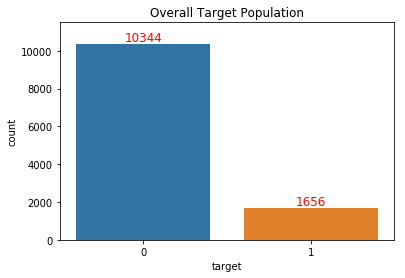

In [11]:
sns.countplot(x="target",data=target)
ax = plt.gca()
def roundup(x):
    return 100 + int(math.ceil(x / 100.0)) * 100
y_max = df['target'].value_counts().max() 
ax.set_ylim([0, roundup(y_max)+1000])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')
plt.title('Overall Target Population')
plt.show()

## Descriptive Statistics 

In [12]:
df=users.merge(target, left_on='object_id', right_on='user_id', how='inner')
df['creation_time']=pd.to_datetime(df['creation_time'], format='%m/%d/%Y %H:%M', errors='raise', infer_datetime_format=False, exact=True)

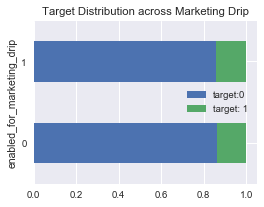

In [13]:
tps = df.pivot_table(values=['object_id'], 
                      index='enabled_for_marketing_drip',
                      columns='target',
                      aggfunc='count')

tps = tps.div(tps.sum(1), axis=0)
sns.set(rc={"figure.figsize": (4, 3)})
sns.set(font_scale = 0.95)
#fig, ax = plt.subplots(figsize=a4_dims)
#plt.title('Target Distribution across Mailing List')
tps.plot(kind='barh', stacked=True,legend=False)
plt.title('Target Distribution across Marketing Drip')
plt.legend(['target:0','target: 1'],loc=0)

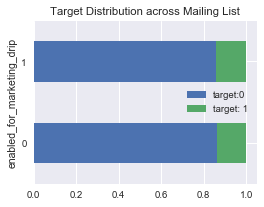

In [14]:
tps1 = df.pivot_table(values=['object_id'], 
                      index='opted_in_to_mailing_list',
                      columns='target',
                      aggfunc='count')

tps1 = tps.div(tps.sum(1), axis=0)
sns.set(rc={"figure.figsize": (4, 3)})
sns.set(font_scale = 0.95)
#fig, ax = plt.subplots(figsize=a4_dims)
#plt.title('Target Distribution across Mailing List')
tps1.plot(kind='barh', stacked=True,legend=False)
plt.title('Target Distribution across Mailing List')
plt.legend(['target:0','target: 1'],loc=0)

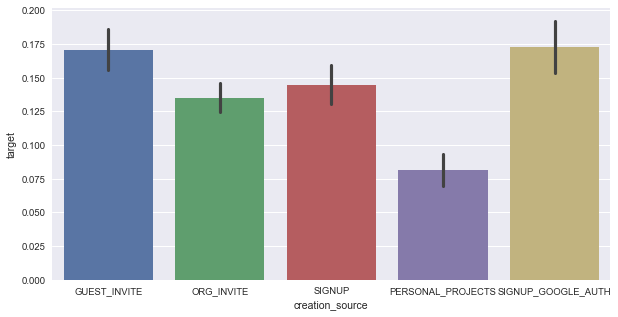

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (5, 5)})
sns.set(font_scale = 0.95)

a4_dims = (10, 5)
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x="creation_source", y="target",data=df) 
#plt.legend(loc='upper right')
plt.show()

## Variable Pre-processing 

### Check Variables that have high levels

In [16]:
categorical =[]
for i in df.columns:
    if len(df[i].unique().tolist()) > 10:
        print(i)
    else:
        continue

object_id
creation_time
name
email
last_session_creation_time
org_id
invited_by_user_id
email_domain
user_id


In [17]:
df=df.drop(['name','email','last_session_creation_time','org_id','email_domain','user_id'],axis=1)

In [18]:
df.isnull().sum()

object_id                        0
creation_time                    0
creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
invited_by_user_id            5583
target                           0
dtype: int64

In [19]:
df=df.fillna(0)

## Feature Engineering 

In [20]:
df['invited_by_user'] = np.where(df['invited_by_user_id']==0, 0, 1)
df=df.drop(['invited_by_user_id'],axis=1)

In [21]:
df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
creation_source                       object
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
target                                 int64
invited_by_user                        int32
dtype: object

In [22]:
le = preprocessing.LabelEncoder()
le.fit(df['creation_source'])
df['creation_source'] = le.transform(df['creation_source'])

In [23]:
df['Tenure'] = ((datetime.datetime.today() - df['creation_time'])/np.timedelta64(1, 'D'))
df=df.drop(['creation_time'],axis=1)
df = df.round(2)

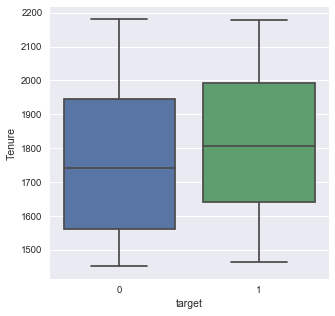

In [24]:
sns.boxplot(x="target", y="Tenure", data=df)
plt.show()

## Multi collinearity check 

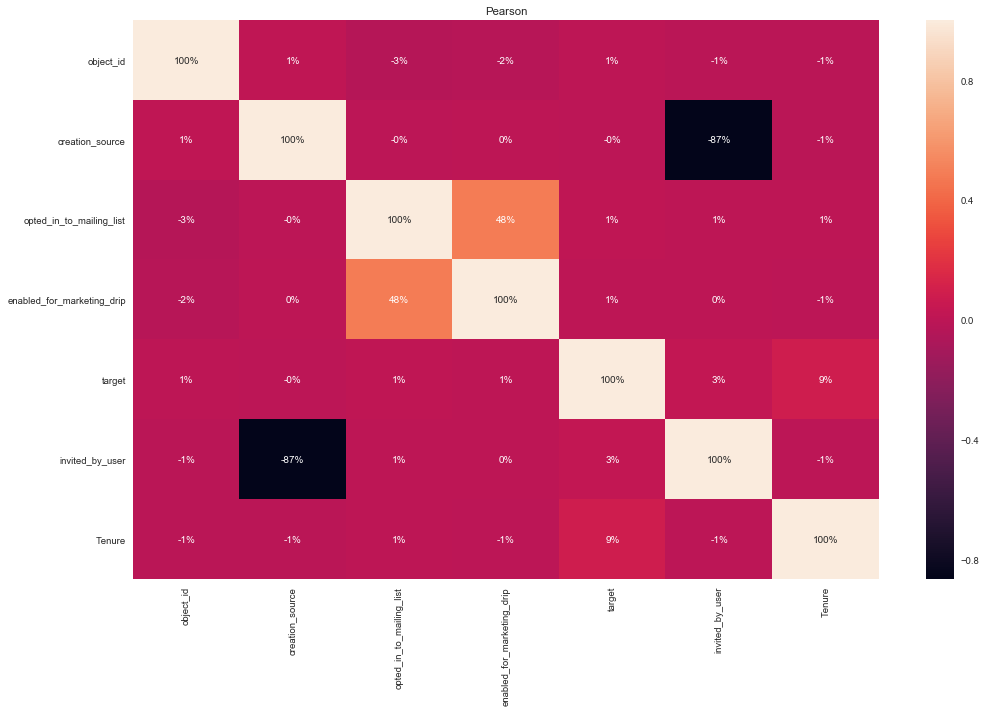

In [113]:
columns1 = df.columns
f, (ax1) = plt.subplots(1, figsize=(15,10))
ax1.set_title("Pearson")
#assign the cbar to be in that axis using the cbar_ax kw
sns.heatmap(df.corr(), ax=ax1 ,yticklabels=columns1,xticklabels=columns1, annot=True, fmt='.0%')
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
ax1.figure.tight_layout()
plt.show()

## Variance Inflation Factor

In [114]:
all_input_var = ["creation_source",
"opted_in_to_mailing_list",
"enabled_for_marketing_drip",
#"invited_by_user",
"Tenure"
]
vif = []
for i in range(df[all_input_var].shape[1]):
    vif.append(variance_inflation_factor(df[all_input_var].values,i))
vif = pd.DataFrame(vif)
names = pd.DataFrame(df[all_input_var].columns.tolist())
t = pd.concat([names,vif],axis=1)
t.columns = ['variable','vif_score']

In [115]:
t

,variable,vif_score
0,creation_source,2.690754
1,opted_in_to_mailing_list,1.736365
2,enabled_for_marketing_drip,1.533215
3,Tenure,3.029834


In [116]:
a= t.loc[t['vif_score'] <=5,['variable']].values.flatten().tolist()

## Random Forest with Grid Search 

In [117]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3,random_state=1991)
train_x = train[a]
train_y = train.target
test_x = test[a]
test_y = test.target
features = train_x.columns

In [118]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold
grid_1 = { "n_estimators"      : [100,200,500],
               "criterion"         : ["gini","entropy"],
               "max_features"      : ['auto'],
               "max_depth"         : [3,4,6,10],
               "min_samples_split"  : [3]
         }
RF=RandomForestClassifier()
grid_search = GridSearchCV(RF, grid_1, n_jobs=-1, cv=5)
grid_search.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 500], 'criterion': ['gini', 'entropy'], 'max_features': ['auto'], 'max_depth': [3, 4, 6, 10], 'min_samples_split': [3]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [119]:
grid_search.best_score_

0.8592857142857143

In [120]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 100}

In [121]:
from sklearn.metrics import *
from numpy import *
def Performance(Model,train_y,train_x,test_y,test_x):    
    %matplotlib inline
    plt.subplots_adjust(left=0.0001, bottom=None, right=1.8, top=None, wspace=None, hspace=None)
    fpr_tr, tpr_tr, _ = roc_curve(train_y, Model.predict_proba(train_x)[:,1])
    fpr_tt, tpr_tt, _ = roc_curve(test_y, Model.predict_proba(test_x)[:,1])
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    roc_auc_tt = auc(fpr_tt, tpr_tt)
    plt.subplot(1,2,1)
    plt.title('ROC Curve')
    plt.plot(fpr_tr, tpr_tr, color = 'green', label = 'Train = %0.2f' % roc_auc_tr)
    plt.plot(fpr_tt, tpr_tt, color = 'blue', label = 'Test = %0.2f' % roc_auc_tt)
    plt.xticks(arange(0,1,0.1))
    plt.yticks(arange(0,1,0.1))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    #plt.grid()

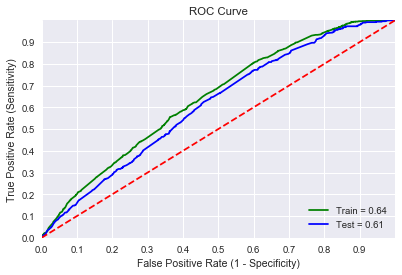

In [122]:
Performance(grid_search,train_y,train_x,test_y,test_x)

## Calculate Feature Importance 

In [123]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(train_x, train_y)
# display the relative importance of each attribute
Variables = model.feature_importances_
vars_in_tree = train_x.columns
temp_df = pd.DataFrame({'Variable': vars_in_tree,'Variable_Importance': Variables})
temp_df.sort_values('Variable_Importance', ascending=False)

,Variable,Variable_Importance
3,Tenure,0.964550
0,creation_source,0.023966
1,opted_in_to_mailing_list,0.007414
2,enabled_for_marketing_drip,0.004069


## Post Model Analysis 

### Select a cut off based on F Score 

In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

X = train_x
y = train_y
def cutoff_predict(clf,X,cutoff):
    return(clf.predict_proba(X)[:,1] > cutoff).astype(int)

scores = []
def custom_f1(cutoff):
    def f1_cutoff(clf,X,y):
        ypred = cutoff_predict(clf,X, cutoff)
        return sklearn.metrics.f1_score(y, ypred)
    return f1_cutoff

for cutoff in np.arange(0.1,0.6,0.1):
    clf = RandomForestClassifier(n_estimators = 100,criterion='gini', max_depth=3, max_features='auto')
    validated = cross_val_score(clf,train_x,train_y, cv = 5, scoring = custom_f1(cutoff))
    scores.append(validated)

C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

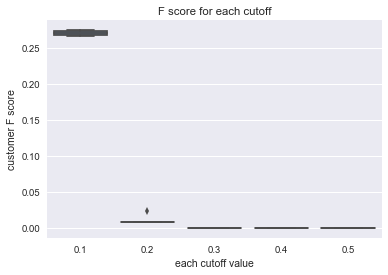

In [126]:
x =np.array([0.1,0.2,0.3,0.4,0.5])
sns.boxplot(x,y=scores)
plt.title('F score for each cutoff')
plt.xlabel('each cutoff value')
plt.ylabel('customer F score')
plt.show()

In [128]:
ypred = grid_search.predict_proba(test_x)
ypred[ypred<0.18] = 0
ypred[ypred>=0.18] = 1
y_pred = [item[1] for item in ypred]

In [129]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_y, y_pred,average = 'binary')

(0.21120689655172414, 0.10337552742616034, 0.1388101983002833, None)

In [130]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, y_pred)

0.8311111111111111

In [131]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(test_y, y_pred)
confusion_matrix

array([[2943,  183],
       [ 425,   49]], dtype=int64)

In [132]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(test_y, y_pred)
cm = np.array(confusion_matrix)
cm

array([[2943,  183],
       [ 425,   49]], dtype=int64)

In [133]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(test_y, y_pred)
cm = np.array(confusion_matrix)
cm

array([[2943,  183],
       [ 425,   49]], dtype=int64)

In [134]:
results = pd.concat([test_x,test_y],axis=1)
results.reset_index(drop=True, inplace=True)
prob= grid_search.predict_proba(test_x)
predicted = pd.DataFrame({'SCORE':prob[:,1],'PRED':y_pred})
predicted.reset_index(drop=True, inplace=True)
ddf = pd.concat([results, predicted], axis=1) 
ddf['Decile']=pd.qcut(ddf['SCORE'], 10, labels = arange(10,0,-1))
Decile = "Decile"

In [135]:
def score_plots(df, target, decile):
    
    fin_res = pd.DataFrame(arange(10,0,-1),columns = ['Decile'])
    fin_res['Act_Target']=(df.loc[df['target'] == 1].groupby([decile],as_index=False).count())['PRED']
    fin_res['Act_Non_Target']=(df.loc[df['target'] == 0].groupby([decile],as_index=False).count())['PRED']
    fin_res['Pred_Target']=(df.groupby([decile],as_index=False).sum())['SCORE']
    fin_res['Act_1_pct'] = (fin_res['Act_Target']/sum(fin_res['Act_Target']))
    fin_res['Act_0_pct'] = (fin_res['Act_Non_Target']/sum(fin_res['Act_Non_Target']))
    fin_res['Act_Cum_Tar'], fin_res['Act_Cum_1_pct'], fin_res['Act_Cum_0_pct'], fin_res['Lift'] = " ", " ", " ", " "
    r1 = 0
    r0 = 0
    d1 = 0
    for j in range(10):
        d1 = d1 + fin_res['Act_Target'][j]
        r1 = r1 + fin_res['Act_1_pct'][j]
        r0 = r0 + fin_res['Act_0_pct'][j]
        fin_res['Act_Cum_Tar'][j] = d1
        fin_res['Act_Cum_1_pct'][j] = r1
        fin_res['Act_Cum_0_pct'][j] = r0
        fin_res['Lift'][j] = r1*100 - (j+1)*10
    fin_res['KS'] = abs(fin_res['Act_Cum_1_pct'] - fin_res['Act_Cum_0_pct'])*100
    fin_res['fin_decile'] = arange(1,11,1)
    
    plt.subplots_adjust(left=0.0001, bottom=None, right=2.5, top=None, wspace=None, hspace=None)
    plt.subplot(1,3,2)
    plt.title("Actual vs Predicted")
    plt.plot(fin_res['fin_decile']*10,fin_res['Act_Target'], color = 'green', label = 'Actual', marker='d')
    plt.plot(fin_res['fin_decile']*10,fin_res['Pred_Target'], color = 'blue', label = 'Predicted', marker='*')
    plt.xticks(arange(0,110,10))
    plt.yticks(arange(0,110,10))
    plt.legend()
    plt.xlabel('% of population')
    plt.ylabel('Target Population %')
    plt.grid()

C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\si

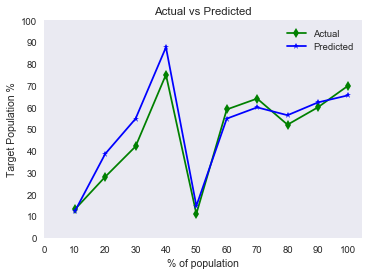

In [136]:
score_plots(ddf,target,Decile)

## Understand how variables are affecting the target 

In [137]:
dftest=users.merge(target, left_on='object_id', right_on='user_id', how='inner')
dftest=dftest.drop(['name','email','last_session_creation_time','user_id','email_domain','org_id','invited_by_user_id'],axis=1)
dftest=dftest.fillna(0)
dftest['creation_time']=pd.to_datetime(dftest['creation_time'], format='%m/%d/%Y %H:%M', errors='raise', infer_datetime_format=False, exact=True)
dftest['Tenure'] = ((datetime.datetime.today() - dftest['creation_time'])/np.timedelta64(1, 'D'))
dftest=dftest.drop(['creation_time'],axis=1)
dftest = dftest.round(2)

In [138]:
creation_source = pd.get_dummies(dftest['creation_source'],drop_first=False)
creation_source.head()

,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [139]:
dftest.drop(['creation_source'],axis=1,inplace=True)
dftest.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,target,Tenure
0,1,1,0,0,1489.40
1,2,0,0,1,1647.40
2,3,0,0,0,1887.59
3,4,0,0,0,1825.22
4,5,0,0,0,1949.13


In [140]:
dftest_dmy = pd.concat([dftest,creation_source],axis=1)
dftest_dmy.columns

Index(['object_id', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'target', 'Tenure', 'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS',
       'SIGNUP', 'SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [141]:
dftest_dmy.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,target,Tenure,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,1,0,0,1489.40,1,0,0,0,0
1,2,0,0,1,1647.40,0,1,0,0,0
2,3,0,0,0,1887.59,0,1,0,0,0
3,4,0,0,0,1825.22,1,0,0,0,0
4,5,0,0,0,1949.13,1,0,0,0,0


In [142]:
x = dftest_dmy.ix[:,(1,2,4,5,6,8,9)].values
y = dftest_dmy.ix[:,3].values

C:\Users\ppital499\AppData\Local\Continuum\anaconda3.6\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [143]:
all_input_var = ['opted_in_to_mailing_list','Tenure','enabled_for_marketing_drip','GUEST_INVITE',
       'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH']
vif = []
for i in range(dftest_dmy[all_input_var].shape[1]):
    vif.append(variance_inflation_factor(dftest_dmy[all_input_var].values,i))
vif = pd.DataFrame(vif)
names = pd.DataFrame(dftest_dmy[all_input_var].columns.tolist())
t = pd.concat([names,vif],axis=1)
t.columns = ['variable','vif_score']

In [144]:
t

,variable,vif_score
0,opted_in_to_mailing_list,1.736430
1,Tenure,3.107140
2,enabled_for_marketing_drip,1.533191
3,GUEST_INVITE,1.493311
4,PERSONAL_PROJECTS,1.485202
5,SIGNUP,1.469108
6,SIGNUP_GOOGLE_AUTH,1.312933


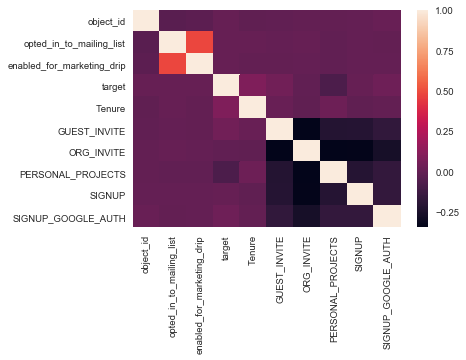

In [145]:
sns.heatmap(dftest_dmy.corr())
plt.show()

In [146]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression

logit = sm.Logit(y, x).fit()
x=logit.summary(xname = (['opted_in_to_mailing_list', 'enabled_for_marketing_drip','Tenure','GUEST_INVITE','Personal_projects','SIGN_UP','SIGN_UP_AUTH']))
print(x)

Optimization terminated successfully.
         Current function value: 0.409517
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11993
Method:                           MLE   Df Model:                            6
Date:                Sun, 20 May 2018   Pseudo R-squ.:                -0.02043
Time:                        13:26:59   Log-Likelihood:                -4914.2
converged:                       True   LL-Null:                       -4815.8
                                        LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
opted_in_to_mailing_list      -0.0128      0.069     -0.186      0.852      

~Prajakta Pitale